In [2]:
# setup
import pathlib as pl
import math

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()

%matplotlib inline
# helper functions

def prettyPrintAllocations(procTestLists):
    """
        Pretty-prints a list of lists of test assignments for each processor
    """
    pWidth = 1+len(str(len(procTestLists)))
    tWidth = 1+len(str(max(e for l in procTestLists for e in l)))
    for pIdx, tList in enumerate(procTestLists):        
        print("proc {:>{pWidth}} > {}".format(pIdx, " ".join("{:>{tWidth}}".format(t, tWidth=tWidth) for t in tList),
              pWidth=pWidth))

def prettyPrintStats(procTestLists):
    """
        Pretty-prints a list of the number and sums of test assignments for each processor
    """
    counts = [len(l) for l in procTestLists]
    sums = [sum(l) for l in procTestLists]

    pWidth = 1+len(str(len(procTestLists)))
    cntWidth = 1+len(str(max(counts)))
    sumWidth = 1+len(str(max(int(s) for s in sums)))
    for pIdx, (pCnt, pSum) in enumerate(zip(counts, sums)):    
        print("proc {:>{pWidth}} > #{:>{cntWidth}} tests Σ{:>{sumWidth}.2f} seconds".format(pIdx, pCnt, pSum/1000,
                cntWidth=cntWidth, sumWidth=sumWidth, pWidth=pWidth))

def plotTestRuntimeDistribution(testRuntimes):
    tCount = len(testRuntimes)

    unit = 10**int(math.log10(tCount))
    maxTick = unit * (tCount // unit)
    
    plt.plot(range(tCount), sorted(testRuntimes, reverse=True))
    plt.xticks(range(0, 1+maxTick, int(maxTick/5)))
    plt.ylabel("runtime / msecs")
    plt.xlabel("tests sorted by runtime")
    plt.show()
    
def plotDistributions(pSortedSums):
    seriesCount = len(pSortedSums[0])
    pSums = [sum(l)/1000 for l in pSortedSums]
    processorTimes = [s/seriesCount for s in pSums]

    plt.bar(range(procCount),processorTimes)
    plt.ylabel("allocation time total / seconds")
    plt.xlabel("processors sorted by total allocation")
    plt.xticks([])
    plt.show()

# The "Long Pole" Effect in Gradle's Test Execution

When many tests with different runtimes are executed in parallel on multiple processors, the overall test runtime is that of the processor with the highest load as measured by the summed test execution times. Ideally, this approaches the quotient between total test runtime and number of processors.

However, when one processor is assigned an unproportionally high load of tests, the overall runtime will be dominated by this processor: It will have to continue to work off tasks after all other processors have finished, thus becoming the "long pole" in the runtime. [This problem can occur in Gradle's parallel test execution](https://github.com/gradle/gradle/issues/2669).

In this notebook, we take a look at how Gradle (in its current versions - 5.x and early 6) schedules tests and how the long pole problem emerges. We investigate an option to improve the situation.

A point to make here is that Gradle does not split up a test class for parallelization, so the smallest unit which we distribute is the test class; as we will see below, if we have classes containing long(er)-running, integration-like tests, this increases the potential for running into the "long pole" problem. When we talk about a "test" below, this will usually translate to a test class (JUnit or similar).

## Scheduling

Gradle statically pre-assigns tests to parallel processors using a round-robin approach. The allocation is based solely on the incoming order of the test classes; it does not take into account test size or other information:

In [3]:
def roundRobin(tests, procCount):
    """ 
    Takes a list of test items and distributes them in a straight-forward round-robin
    fashion amongst the number of given processors.
    :return: a list of `procCount` lists L1 ...Lx, where each Li denotes the tests assigned
             to processor #x.
    """
    procs = [[] for _i in range(procCount)]

    for tIdx, test in enumerate(tests):
        pos = tIdx % procCount
        procs[pos].append(test)
    return procs

E.g., with 20 tests and 5 processors, they would be allocated as follows:

In [4]:
prettyPrintAllocations(roundRobin(range(20), 5))

proc  0 >   0   5  10  15
proc  1 >   1   6  11  16
proc  2 >   2   7  12  17
proc  3 >   3   8  13  18
proc  4 >   4   9  14  19


So, if tests **0**, **5**, and **10** happen to take very long, processor **0** would become the long pole in this scenario. If the test number is not a multiple of the number of processors, not all processors will get the same number of tests, but the difference in test numbers between two processors will be at most one:

In [5]:
prettyPrintAllocations(roundRobin(range(8), 3))

proc  0 >  0  3  6
proc  1 >  1  4  7
proc  2 >  2  5


## Experiments

We can take a statistical look at how round-robin scheduling affects the processor loads.

### Getting Runtime Examples

For test runtime data, we start with Gradle's own test classes. In Gradle's own `build.gradle.kts`, we modify the `allprojects` configuration to make the test classes log their runtimes:

```kotlin
tasks.withType<Test> {
        outputs.upToDateWhen { false }
        addTestListener(object : TestListener {
            override fun beforeSuite(suite: TestDescriptor) {}
            override fun beforeTest(testDescriptor: TestDescriptor) {}
            override fun afterTest(testDescriptor: TestDescriptor, result: TestResult) {
            }
            override fun afterSuite(suite: TestDescriptor, result: TestResult) {
                val duration = result.endTime - result.startTime
                println(">>> $suite\t${duration}")
            }
        })
    }
```

The resulting times for a few test series are collected in the folder `gradle_test_stats` (see the scripts `timeGradleTests.sh` and `timesOnly.sh` for their generation). Sorting by runtime in descending order and averaging over the series gives an impression of the test classes' runtime distribution:

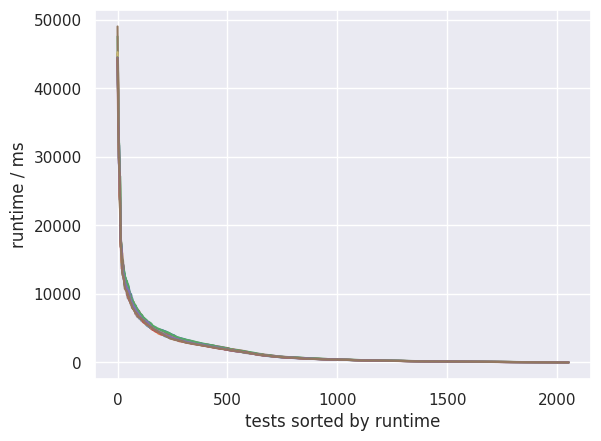

In [6]:
timesFiles = pl.Path("gradle_test_stats").glob("*.times")
sums, seriesCount = None, 0
for tfName in timesFiles:
    with open(tfName) as tff:
        vals = sorted((int(l.strip()) for l in tff), reverse=True)
        sums = vals if sums is None else [v+s for v,s in zip(vals, sums)]
        seriesCount += 1
    plt.plot(vals)
plt.xlabel("tests sorted by runtime")
plt.ylabel("runtime / ms")
plt.show()

In [7]:
import statistics as stats
runtimes = [s/seriesCount for s in sums]
longest, median, shortest = runtimes[0], stats.median(runtimes), runtimes[-1]
print(f"Evaluated {seriesCount} overall test executions with {len(sums)} test classes each.\n"
      f"The total runtime for all test classes was {sum(runtimes)/1000:.2f} seconds on average.\n"
      f"On average, the longest class runtime was {longest/1000:.2f} seconds,\n"
      f"the shortest {shortest:.2f} milliseconds, "
      f"with a median of {median:.2f} milliseconds.")

Evaluated 16 overall test executions with 2053 test classes each.
The total runtime for all test classes was 3348.34 seconds on average.
On average, the longest class runtime was 45.06 seconds,
the shortest 1.44 milliseconds, with a median of 388.00 milliseconds.


The above graph should actually be made up of bars, since each x position is one test, but unfortunately that looked crappy. It looks like some kind of [exponential](https://en.wikipedia.org/wiki/Exponential_distribution) or power law distribution: Very few test of comparatively high runtimes, and a long tail of very short-running tests.

If run entirely sequentially, we could expect the test classes to take approx. 55 minutes.

### Simulating Load Distribution

Given these runtimes, we can simulate what the resulting processor load distributions would be with round robin. Since the ordering in Gradle is currently agnostic with regard to size, we shuffle the test runtimes first. The result might look like this:

In [8]:
import random
shuffledTimes = list(runtimes)
random.shuffle(shuffledTimes)

procCount = 4

prettyPrintStats(roundRobin(shuffledTimes, procCount))

proc  0 > # 514 tests Σ 813.73 seconds
proc  1 > # 513 tests Σ 860.20 seconds
proc  2 > # 513 tests Σ 810.94 seconds
proc  3 > # 513 tests Σ 863.47 seconds


The distribution among the processors will vary, but it will most likely not be even. We can sort the processors by assigned sums, and repeat the whole procedure a few times to get an impression of the skew:

In [9]:
def repeatedlyAllocate(testTimes, procCount, seriesCount):
    """
        Shuffle the given test times and repeatedly allocate them to
        the given number of processors.
        
        :return: a list of 'procCount' elements,
                 where each list contains the 'seriesCount' test allocations to that processor
    """

    shuffledTimes = testTimes
    # for each processor, keep a list of the sum over the tests,
    # sorted by summed allocation
    pSortedSums = [[] for _ in range(procCount)]
    for _s in range(seriesCount):
        random.shuffle(shuffledTimes)
        # longest first:
        sortedSums = sorted([sum(l) for l in roundRobin(shuffledTimes, procCount)], reverse=True)
        for pList, s in zip(pSortedSums, sortedSums):
            pList.append(s)

    return pSortedSums

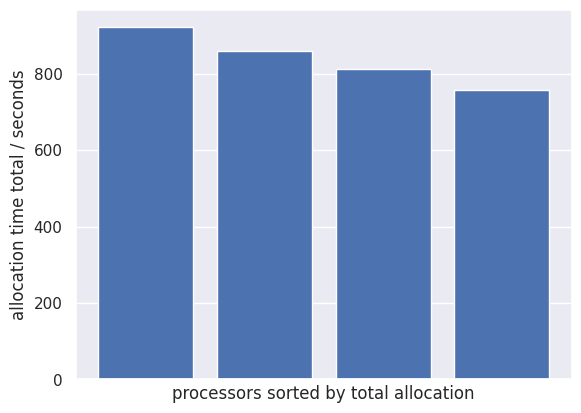

In [11]:
seriesCount = 2000
pSortedSums = repeatedlyAllocate(shuffledTimes, procCount, seriesCount)
plotDistributions(pSortedSums)

In [12]:
pSums = [sum(l) for l in pSortedSums]
processorTimes = [(s/1000)/seriesCount for s in pSums]

for pIdx, pTimes in enumerate(processorTimes):
    print(f"Proc {pIdx} > {pTimes:.2f} seconds average allocation")
diff = processorTimes[0]-processorTimes[-1]
print(f"On average, the longest-running proc took {diff:.2f} seconds ({diff/processorTimes[-1]:.1%}) longer than the shortest-running one.")

Proc 0 > 920.80 seconds average allocation
Proc 1 > 859.45 seconds average allocation
Proc 2 > 811.17 seconds average allocation
Proc 3 > 756.91 seconds average allocation
On average, the longest-running proc took 163.89 seconds (21.7%) longer than the shortest-running one.


There is a slight skew, although it (probably - since this depends on random values) does not seem that big. However, there are two _buts_ here:

### Bad Ratios

This was only the average ratio. The complete histogram over the ratios of highest load / smallest load for the different series looks like this:

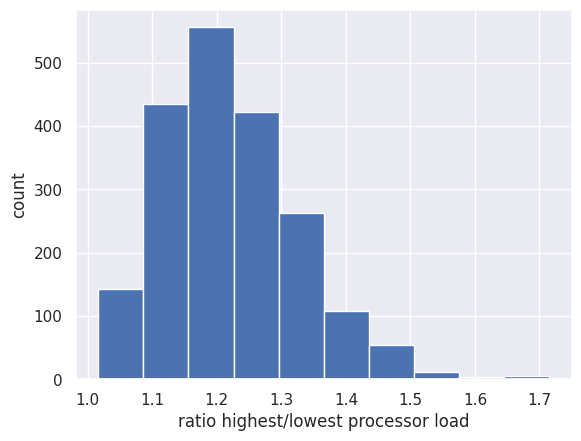

In 21.10% of the cases, the highest load is at least 1.3 times the lowest load.
The maximum ratio of highest to lowest load is 1.72.


In [13]:
def plotAllocationRatioDistribution(pSortedSums, tooMuchThreshold=1.3):
    highestLoadProc, lowestLoadProc = pSortedSums[0], pSortedSums[-1]

    ratios = [h/l for h,l in zip(highestLoadProc, lowestLoadProc)]
    plt.hist(ratios)
    plt.xlabel("ratio highest/lowest processor load")
    plt.ylabel("count")
    plt.show()

    ratioOfTooMuchRatios = len([r for r in ratios if r >= tooMuchThreshold])/len(ratios)
    print(f"In {ratioOfTooMuchRatios:.2%} of the cases, the highest load is at least {tooMuchThreshold} times the lowest load.")
    print(f"The maximum ratio of highest to lowest load is {max(ratios):.2f}.")

plotAllocationRatioDistribution(pSortedSums)

We can pick out and plot the worst allocation:

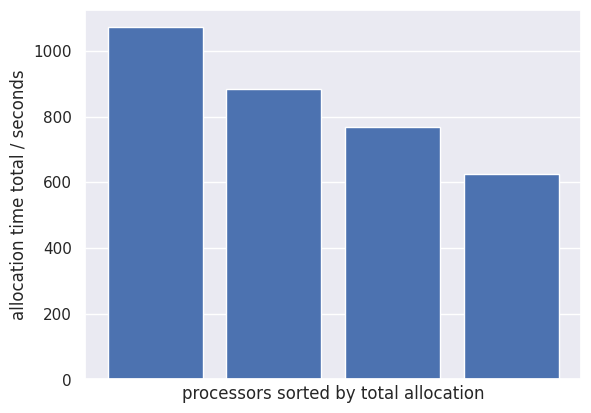

In [14]:
_maxRatio, maxIndex = max((high/low, i) for i, (high, low) in enumerate(zip(pSortedSums[0], pSortedSums[-1])))
maxSkewAllocation = [[procList[maxIndex]] for procList in pSortedSums]
plotDistributions(maxSkewAllocation)

In practice, AFAIK, for a given set of test classes, the order in which they are processed in Gradle is stable. So any particularly bad example of the test series above might be one constantly encountered for a given set of test classes. Apart from that, a single new test class can make the ordering and hence the class allocation and overall test runtime jump all of a sudden.

## Longer tests

The Gradle test classes collection represents a rather ideal case: It contains very many test classes with mostly very short runtimes (<1 sec). The results look different when you add test classes with runtimes in the minutes. We can generate a collection of random times (with an admittedly somewhat arbitrarily chosen power law distribution) and add them to the mix:

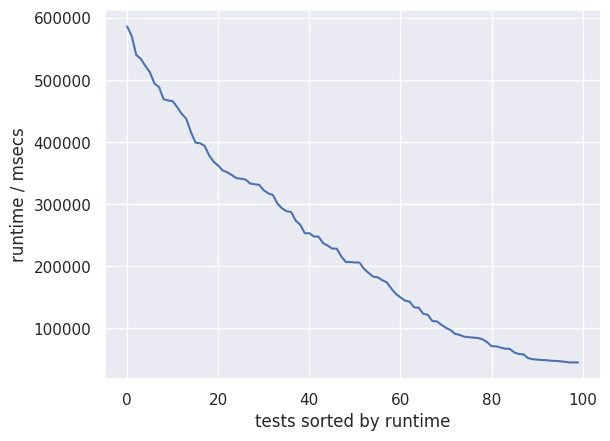

In [15]:
import numpy as np

longTestsCount = 100
maxDurationMs = 10 * 60 * 1000 # 10 mins in ms
minDurationMs = 45 * 1000 # 45 secs

longerRuntimes = [(maxDurationMs-minDurationMs)*v+minDurationMs for v in np.random.power(0.5, size=(longTestsCount,))]
plotTestRuntimeDistribution(longerRuntimes)

Adding those to our Gradle tests gives the following overall test times distribution:

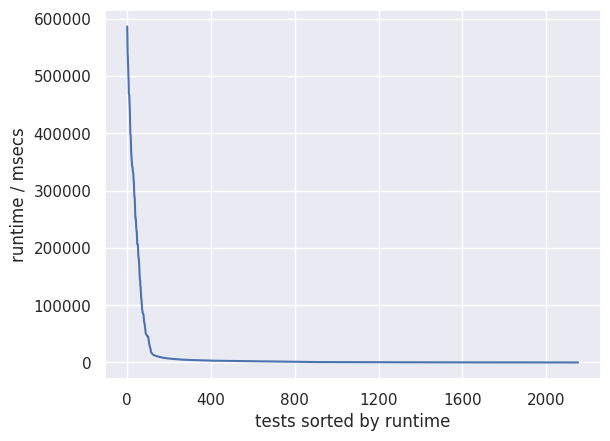

Gradle test times = 3348.3 secs
Longer test times = 23099.5 secs
Total  test times = 26447.8 secs


In [16]:
allRuntimes = longerRuntimes + runtimes

plotTestRuntimeDistribution(allRuntimes)
print(f"Gradle test times = {sum(runtimes)/1000:.1f} secs")
print(f"Longer test times = {sum(longerRuntimes)/1000:.1f} secs")
print(f"Total  test times = {sum(allRuntimes)/1000:.1f} secs")

And allocating these tests gives a higher load skew:

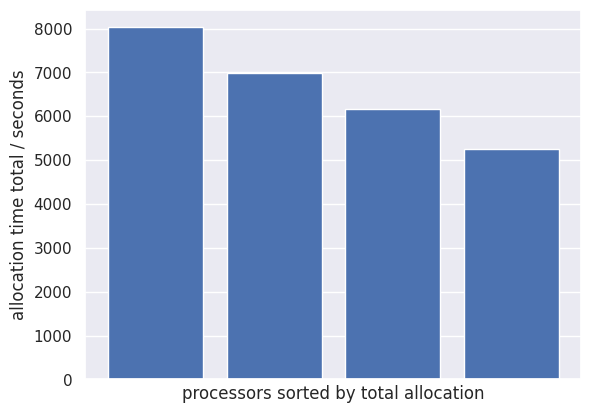

In [17]:
allSortedSums = repeatedlyAllocate(allRuntimes, procCount, seriesCount)
plotDistributions(allSortedSums)

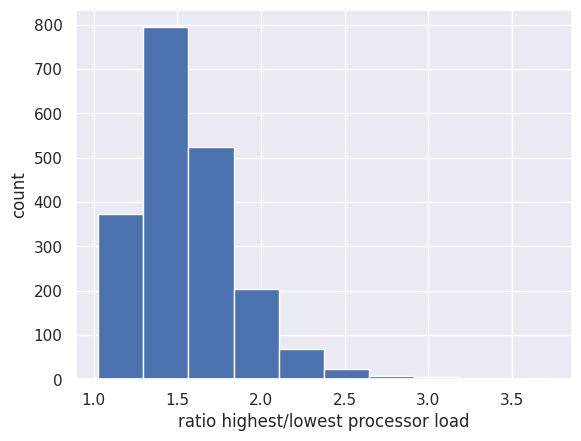

In 51.05% of the cases, the highest load is at least 1.5 times the lowest load.
The maximum ratio of highest to lowest load is 3.72.


In [18]:
plotAllocationRatioDistribution(allSortedSums, tooMuchThreshold=1.5)

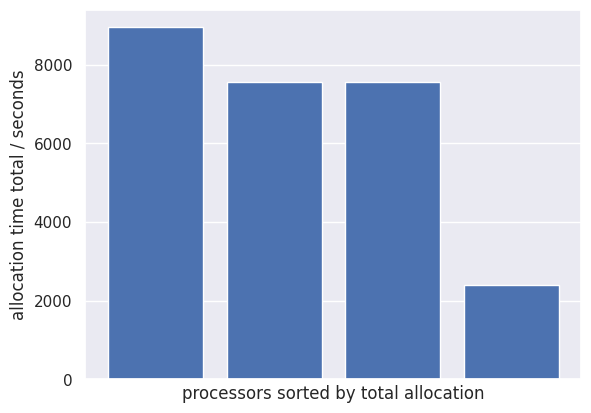

In [19]:
_maxRatio, maxIndex = max((high/low, i) for i, (high, low) in enumerate(zip(allSortedSums[0], allSortedSums[-1])))
maxSkewAllocation = [[procList[maxIndex]] for procList in allSortedSums]
plotDistributions(maxSkewAllocation)

In all likelihood, that distribution looks "long-poley". (Or "short-poley" with a single lazy processor, or just extremely skewed, depending on how the random values came out.) At any rate, the lowest and highest loads are bound to be far more apart than they should be.

## Effect Of Sorting

Gradle records test durations, so we can use that information to fix the ordering of the tests for allocation. [This has been proposed as a simple fix by the Gradle team themselves](https://github.com/gradle/gradle/issues/2669#issuecomment-400261249).

Trying it out is straight-forward:

In [20]:
allRuntimesSorted = sorted(allRuntimes, reverse=True)
allocationBySorting = roundRobin(allRuntimesSorted, procCount)
prettyPrintStats(allocationBySorting)

proc  0 > # 539 tests Σ 6838.84 seconds
proc  1 > # 538 tests Σ 6696.41 seconds
proc  2 > # 538 tests Σ 6535.56 seconds
proc  3 > # 538 tests Σ 6376.99 seconds


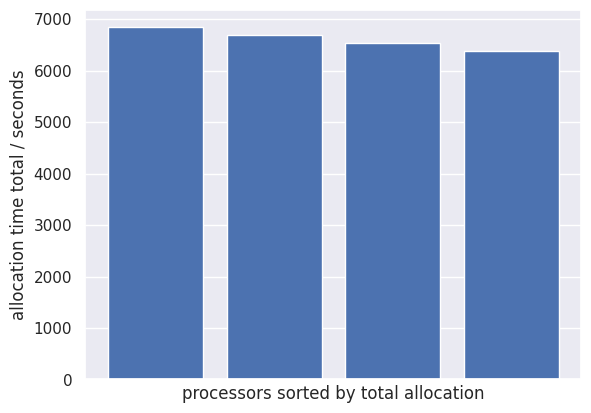

In [21]:
summedAllocations = [[sum(procL)] for procL in allocationBySorting]
plotDistributions(summedAllocations)

In [22]:
roRoRatio = (summedAllocations[0]/summedAllocations[-1][0])[0]
print(f"For the allocation with sorting, the ratio between highest and lowest load is {roRoRatio:.2f} (or an increase of {roRoRatio-1:.2%}).")

For the allocation with sorting, the ratio between highest and lowest load is 1.07 (or an increase of 7.24%).


The allocation across the processors is clearly more even. We can also contrast this specific allocation with the set of random ones from the previous experiments:

In [23]:
allRatios = [high/low for high, low in zip(allSortedSums[0], allSortedSums[-1])]
equalOrHigherRatios = [r for r in allRatios if r > roRoRatio]
print(f"Of the random allocations, {len(equalOrHigherRatios)/len(allRatios):.2%} have a worse highest/lowest load ratio than the allocation with sorting.")

Of the random allocations, 99.40% have a worse highest/lowest load ratio than the allocation with sorting.


It seems fair to say that sorting by size before allocating provides an enormous advantage.

However, combining sorting with round robin has the flaw of introducing a systematic imbalance: Given *n* processors, we are partitioning the tests into consecutive subsequences of length *n* each. Since the tests are sorted by sice, each subsequence also begins with its largest test and ends with the smallest. And since each subsequence is assigned from processor *#0* to processor *(n-1)*, the first processor always gets the largest test of each subsequence, and the last processor always the smallest.

## Shifting Round Robin

We can break up the imbalance of sorted allocation with round robin through a minimal change: After every allocation of a test subsequence to the processors, we don't start the next allocation round on the same processor as the last round, but shift one processor ahead. E.g., nine tests allocated to three processors:

In standard round robin, each block of three starts on processor 0:

| test | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 |
| - | - | - | - | - | - | - | - | - | - |
| proc | 0 | 1 | 2 |  |  |  |  |  |  | 
| proc |  |  |  | 0 | 1 | 2 |  |  |  | 
| proc |  |  |  |  |  |  | 0 | 1 | 2 | 

In shifting round robin, the allocations of each block shift through the processors:

| test | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 |
| -    | - | - | - | - | - | - | - | - | - |
| proc | 0 | 1 | 2 |  |  |  |  |  |  |
| proc |  |  |  | 1 | 2 | 0 |  |  |  |
| proc |  |  |  |  |  |  | 2 | 0 | 1 |

As a result, the processors each get a rotating share of each subsequence. E.g., the first processor will get the largest test of the first sequence, but the smallest of the second, and so on. The invariant of the number of tests being distributed as evenly as possible is maintained, but the sizes are "smeared" across the processors. A toy example with tests of simple, linearly increasing sizes illustrates the effect.

Doing standard round robin with sorted tests first:

In [24]:
allocation = roundRobin(sorted([100*i for i in range(1, 21)], reverse=True), 5)
prettyPrintAllocations(allocation)
print()
prettyPrintStats(allocation)

proc  0 >  2000  1500  1000   500
proc  1 >  1900  1400   900   400
proc  2 >  1800  1300   800   300
proc  3 >  1700  1200   700   200
proc  4 >  1600  1100   600   100

proc  0 > # 4 tests Σ 5.00 seconds
proc  1 > # 4 tests Σ 4.60 seconds
proc  2 > # 4 tests Σ 4.20 seconds
proc  3 > # 4 tests Σ 3.80 seconds
proc  4 > # 4 tests Σ 3.40 seconds


In [25]:
def shiftingRoundRobin(tests, procCount):
    """ 
    Takes a list of test items and distributes them in a shifting round-robin
    fashion amongst the number of given processors.
    :return: a list of `procCount` lists L1 ...Lx, where each Li denotes the tests assigned
             to processor #x.
    """
    
    procs = [[] for _i in range(procCount)]

    for tIdx, test in enumerate(tests):
        shift = (tIdx//procCount)%procCount
        pos = (shift + tIdx) % procCount
        procs[pos].append(test)
    return procs

allocation = shiftingRoundRobin(sorted([100*i for i in range(1, 21)], reverse=True), 5)
prettyPrintAllocations(allocation)
print()
prettyPrintStats(allocation)

proc  0 >  2000  1100   700   300
proc  1 >  1900  1500   600   200
proc  2 >  1800  1400  1000   100
proc  3 >  1700  1300   900   500
proc  4 >  1600  1200   800   400

proc  0 > # 4 tests Σ 4.10 seconds
proc  1 > # 4 tests Σ 4.20 seconds
proc  2 > # 4 tests Σ 4.30 seconds
proc  3 > # 4 tests Σ 4.40 seconds
proc  4 > # 4 tests Σ 4.00 seconds


With standard round robin, we get a ratio of 5.0 to 3.4 for highest / lowest processor load. With shifting round robin, this is reduced to 4.4 to 4.0. For our scenario with long tests, the effect is also noticeable:

In [26]:
allRuntimesSorted = sorted(allRuntimes, reverse=True)
shiftingRoRoAllocation=shiftingRoundRobin(allRuntimesSorted, procCount)
prettyPrintStats(shiftingRoRoAllocation)

proc  0 > # 538 tests Σ 6646.99 seconds
proc  1 > # 538 tests Σ 6654.32 seconds
proc  2 > # 539 tests Σ 6567.16 seconds
proc  3 > # 538 tests Σ 6579.34 seconds


In [27]:
shiftingRatio = (shiftingRoRoAllocation[0]/shiftingRoRoAllocation[-1][0])[0]
print(f"For the allocation with sorting, the ratio between highest and lowest load is {shiftingRatio:.2f} (or an increase of {shiftingRatio-1:.2%}).")
allRatios = [high/low for high, low in zip(allSortedSums[0], allSortedSums[-1])]
equalOrHigherRatios = [r for r in allRatios if r > shiftingRatio]
print(f"Of the random allocations, {len(equalOrHigherRatios)/len(allRatios):.2%} have a worse highest/lowest load ratio than sorting + shifting.")

For the allocation with sorting, the ratio between highest and lowest load is 1.10 (or an increase of 9.78%).
Of the random allocations, 98.65% have a worse highest/lowest load ratio than sorting + shifting.


Evidently, this improvement can only happen when sorting the tests first. If we use unsorted input, we get the same random results (so it does not hurt either).

## Side Nodes

1. When we use previous test runtimes to sort the test classes for allocation, we are assuming that these runtimes are a useful statistics for future runtimes. This will fail if the runtimes are not reliable, e.g., if one processor was strained. Using more data from previous runs might make this more stable.
2. When we add new tests to our test collection, tests for which we have no previous runtime information, we cannot do much about them but add them after or before all the other tests and hope for the best.
